In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240819%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240819T060035Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2d3186156b0cd6e313b7a56fd50db4865b46d7b677cdc2e967423de10b2b3e9ef5e7fecf0a9668b0b86dd5c2767d26d22a43cb8d634d209d22a63341c6a0c8be220fa4908b4a7126da1da38edb49eb2e382592dc03eaa7303478d522f49278185b2e9c8aea03c0ae6cb2ec3c3292d670bcd16d8db11ef660ea5106fe754d483426934b10e45783e5d7a54aa0c2d3548c534a5e10837c63dec08421bd30fcef3ca1a905151491ac8e9c0f4112064913ed5fc6301f1d194092bd6122627f04f9857e3f04ee154eb6c8fe7d70b3e58198c5b02895b8bb23cdb25269e187db8dd085c55b50365fb4d77265ae5745ced0bbe5bf3c923b3be9e6d63e3ecf244c8c4f1f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join('/kaggle/input/gtsrb-german-traffic-sign','Train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [ ]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the Model
# Membuat callback EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metrik yang dipantau, misalnya 'val_loss' atau 'val_accuracy'
    patience=5,          # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik pada model
)
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.2647 - loss: 3.8058 - val_accuracy: 0.8206 - val_loss: 0.7636
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6983 - loss: 1.0419 - val_accuracy: 0.8988 - val_loss: 0.3719
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7747 - loss: 0.7648 - val_accuracy: 0.9167 - val_loss: 0.2948
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8086 - loss: 0.6445 - val_accuracy: 0.9341 - val_loss: 0.2468
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8361 - loss: 0.5517 - val_accuracy: 0.9440 - val_loss: 0.1994
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8471 - loss: 0.5133 - val_accuracy: 0.9361 - val_loss: 0.2114
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8569 - loss: 0.4696 - val_accuracy: 0.9528 - val_loss: 0.1641
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8693 - loss: 0.4502 - val_accuracy: 

# 6. Visualizing the performance of the Model during Training Phase

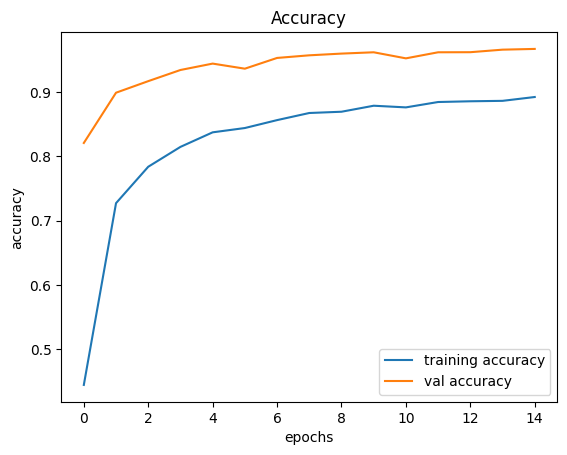

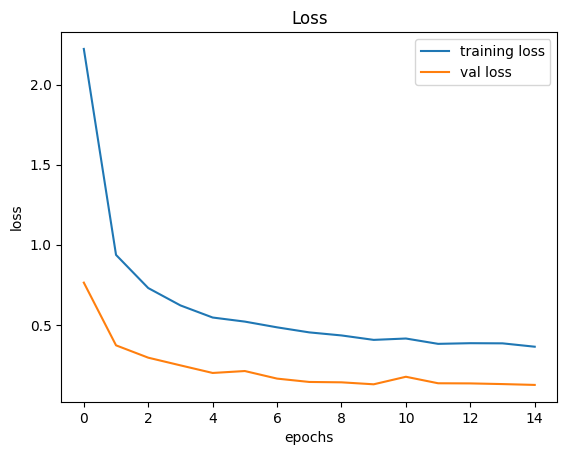

In [ ]:
# Plotting performance graphs
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# tf.keras.models.save_model(model, 'mymodel/')
converter = tf.lite.TFLiteConverter.from_keras_model(model = model)
model_tflite = converter.convert()
open("model.tflite", "wb").write(model_tflite)

Saved artifact at '/tmp/tmpxnyyixrg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  140699139732432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699144800560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699136152800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699136157200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699140381456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699140383744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699140385680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699140387968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699135613888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699135616704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699135618288

973192

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=tf_saved_model mymodel/ tensorflowjs_model

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-d

2024-08-19 08:27:45.490206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 08:27:45.518764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 08:27:45.518820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 08:27:46.570652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-19 08:27:48.887055: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
